# Convolutional Neural Networks (CNN) for handwritten digit classification
Convolutional Neural Networks (CNN) are biologically-inspired variants of MLPs. They consist of multiple layers of small neuron collections, which look at small portions of the input image, called receptive fields. The results of these collections are then tiled so that they overlap to obtain a better representation of the original image; this is repeated for every such layer. 
Because of this, they are able to tolerate translation of the input image.[6]
Convolutional networks may include local or global pooling layers, which combine the outputs of neuron clusters. They also consist of various combinations of convolutional and fully connected layers, with pointwise nonlinearity applied at the end of or after each layer.
To reduce the number of free parameters and improve generalisation capabilities, a convolution operation on small regions of input is introduced. One major advantage of convolutional networks is the use of shared weight in convolutional layers, which means that the same filter (weights bank) is used for each pixel in the layer; this both reduces memory footprint and improves performance.

Compared to other image classification algorithms, convolutional neural networks use relatively little pre-processing. This means that the network is responsible for learning the filters that in traditional algorithms were hand-engineered. The lack of a dependence on prior knowledge and the existence of difficult-to-design, hand-engineered features is a major advantage for CNNs.

More details on CNN can be found:

[Amazing explaination of CNN](http://cs231n.github.io/convolutional-networks/)

[Theano CNN tutorial](http://deeplearning.net/tutorial/lenet.html)


References:

The original paper published by LeCun et al. can be found [here](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).

In [7]:
import os
import sys
sys.path.append('/scripts/')
import timeit

import numpy
import copy

import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv
#import Image

from logistic_sgd import LogisticRegression, load_data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

DATA_PREFIX = '/data/'


In [8]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]

In [9]:
# Plotting function
matplotlib.rc('font', **{'family' : 'sans-serif',
                         'weight' : 'bold',
                         'size'   : 12})
matplotlib.rc('text', **{'usetex' : True})

def plot_mnist(X, y, X_embedded, name, min_dist=10.0):
    fig = matplotlib.figure.Figure(figsize=(6, 6),frameon=False)
    ax = plt.gca()
    plt.title("\\textbf{MNIST dataset} -- Two-dimensional "
          "embedding of handwritten digits with %s" % name)
    plt.setp(ax, xticks=(), yticks=())
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=y, marker="x")

    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = numpy.array([[15., 15.]])
        indices = numpy.arange(X_embedded.shape[0])
        numpy.random.shuffle(indices)
        for i in indices[:5000]:
            dist = numpy.sum((X_embedded[i] - shown_images) ** 2, 1)
            if numpy.min(dist) < min_dist:
                continue
            shown_images = numpy.r_[shown_images, [X_embedded[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X[i].reshape(28, 28),
                                      cmap=cm.gray_r), X_embedded[i])
            ax.add_artist(imagebox)

In [10]:
class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
        """
        Allocate a LeNetConvPoolLayer with shared variable internal parameters.

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dtensor4
        :param input: symbolic image tensor, of shape image_shape

        :type filter_shape: tuple or list of length 4
        :param filter_shape: (number of filters, num input feature maps,
                              filter height, filter width)

        :type image_shape: tuple or list of length 4
        :param image_shape: (batch size, num input feature maps,
                             image height, image width)

        :type poolsize: tuple or list of length 2
        :param poolsize: the downsampling (pooling) factor (#rows, #cols)
        """

        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" /
        #   pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) /
                   numpy.prod(poolsize))
        # initialize weights with random weights
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            numpy.asarray(
                rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv.conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            image_shape=image_shape
        )

        # downsample each feature map individually, using maxpooling
        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # store parameters of this layer
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input

In [11]:
def evaluate_CNN(param):
    """ Demonstrates lenet on MNIST dataset

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
                          gradient)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    :type dataset: string
    :param dataset: path to the dataset used for training /testing (MNIST here)

    :type nkerns: list of ints
    :param nkerns: number of kernels on each layer
    """

    batch_size = param['batch_size']
    nkerns = param['nkerns']
    learning_rate = param['lr']
    n_epochs = param['nepochs']
    
    rng = numpy.random.RandomState(param['seed'])

    datasets = load_data(param['data'])

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
    n_test_batches = test_set_x.get_value(borrow=True).shape[0]
    n_train_batches /= batch_size
    n_valid_batches /= batch_size
    n_test_batches /= batch_size
    
    n_train_batches = int(n_train_batches)
    n_valid_batches = int(n_valid_batches)
    n_test_batches = int(n_test_batches)

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch

    # start-snippet-1
    x = T.matrix('x')   # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # Reshape matrix of rasterized images of shape (batch_size, 28 * 28)
    # to a 4D tensor, compatible with our LeNetConvPoolLayer
    # (28, 28) is the size of MNIST images.
    layer0_input = x.reshape((batch_size, 1, 28, 28))

    # Construct the first convolutional pooling layer:
    # filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
    # maxpooling reduces this further to (24/2, 24/2) = (12, 12)
    # 4D output tensor is thus of shape (batch_size, nkerns[0], 12, 12)
    layer0 = LeNetConvPoolLayer(
        rng,
        input=layer0_input,
        image_shape=(batch_size, 1, 28, 28),
        filter_shape=(nkerns[0], 1, 5, 5),
        poolsize=(2, 2)
    )

    # Construct the second convolutional pooling layer
    # filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
    # maxpooling reduces this further to (8/2, 8/2) = (4, 4)
    # 4D output tensor is thus of shape (batch_size, nkerns[1], 4, 4)
    layer1 = LeNetConvPoolLayer(
        rng,
        input=layer0.output,
        image_shape=(batch_size, nkerns[0], 12, 12),
        filter_shape=(nkerns[1], nkerns[0], 5, 5),
        poolsize=(2, 2)
    )

    # the HiddenLayer being fully-connected, it operates on 2D matrices of
    # shape (batch_size, num_pixels) (i.e matrix of rasterized images).
    # This will generate a matrix of shape (batch_size, nkerns[1] * 4 * 4),
    # or (500, 50 * 4 * 4) = (500, 800) with the default values.
    layer2_input = layer1.output.flatten(2)

    # construct a fully-connected sigmoidal layer
    layer2 = HiddenLayer(
        rng,
        input=layer2_input,
        n_in=nkerns[1] * 4 * 4,
        n_out=500,
        activation=T.tanh
    )

    # classify the values of the fully-connected sigmoidal layer
    layer3 = LogisticRegression(input=layer2.output, n_in=500, n_out=10)

    # the cost we minimize during training is the NLL of the model
    cost = layer3.negative_log_likelihood(y)
    
    pred = theano.function([x],layer3.y_pred)
    
    representation = theano.function([x],layer2.output)

    # create a function to compute the mistakes that are made by the model
    test_model = theano.function(
        [index],
        layer3.errors(y),
        givens={
            x: test_set_x[index * batch_size: (index + 1) * batch_size],
            y: test_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        [index],
        layer3.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    # create a list of all model parameters to be fit by gradient descent
    params = layer3.params + layer2.params + layer1.params + layer0.params

    # create a list of gradients for all model parameters
    grads = T.grad(cost, params)

    # train_model is a function that updates the model parameters by
    # SGD Since this model has many parameters, it would be tedious to
    # manually create an update rule for each model parameter. We thus
    # create the updates list by automatically looping over all
    # (params[i], grads[i]) pairs.
    updates = [
        (param_i, param_i - learning_rate * grad_i)
        for param_i, grad_i in zip(params, grads)
    ]

    train_model = theano.function(
        [index],
        [cost, layer0.W],
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    # end-snippet-1

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')
    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is
                           # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
    validation_frequency = min(n_train_batches, patience / 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    best_params = [numpy.zeros(layer0.W.eval().shape)]
    best_diff = [0]
    best_mean = [0]
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            iter = (epoch - 1) * n_train_batches + minibatch_index

            if iter % 100 == 0:
                print('training @ iter = ', iter)
            cost_ij, params_ij = train_model(minibatch_index)
            

            if (iter + 1) % validation_frequency == 0:

                # compute zero-one loss on validation set
                validation_losses = [validate_model(i) for i
                                     in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f %%' %
                      (epoch, minibatch_index + 1, n_train_batches,
                       this_validation_loss * 100.))

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:

                    #improve patience if loss improvement is good enough
                    if this_validation_loss < best_validation_loss *  \
                       improvement_threshold:
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter
                    
                    best_diff.append( float(numpy.mean(numpy.sqrt((best_params[-1].flatten() - params_ij.flatten())**2))))
                    best_mean.append( float(numpy.mean(params_ij.flatten())))
                    best_params.append(copy.deepcopy(params_ij))

                    # test it on the test set
                    test_losses = [
                        test_model(i)
                        for i in range(n_test_batches)
                    ]
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.), flush=True)

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print('Optimization complete.')
    print('Best validation score of %f %% obtained at iteration %i, '
          'with test performance %f %%' %
          (best_validation_loss * 100., best_iter + 1, test_score * 100.), flush=True)
    return best_params, pred, representation, params_ij, best_diff, best_mean

In [12]:
param = {
    'data': DATA_PREFIX+'/mnist/mnist.pkl.gz',
    'lr': 0.15,
    'batch_size': 500,
    # number of words in the context window
    'nkerns': [20,50],
    'nepochs': 20,
    'seed': 23213
     }
best_params, pred, representation, params_ij, params_diff, params_mean = evaluate_CNN(param)

... loading data
... building the model
... training
training @ iter =  0
epoch 1, minibatch 100/100, validation error 6.880000 %
     epoch 1, minibatch 100/100, test error of best model 7.200000 %
training @ iter =  100
epoch 2, minibatch 100/100, validation error 4.230000 %
     epoch 2, minibatch 100/100, test error of best model 4.650000 %
training @ iter =  200
epoch 3, minibatch 100/100, validation error 3.140000 %
     epoch 3, minibatch 100/100, test error of best model 3.420000 %
training @ iter =  300
epoch 4, minibatch 100/100, validation error 2.620000 %
     epoch 4, minibatch 100/100, test error of best model 2.690000 %
training @ iter =  400
epoch 5, minibatch 100/100, validation error 2.270000 %
     epoch 5, minibatch 100/100, test error of best model 2.290000 %
training @ iter =  500
epoch 6, minibatch 100/100, validation error 2.050000 %
     epoch 6, minibatch 100/100, test error of best model 1.970000 %
training @ iter =  600
epoch 7, minibatch 100/100, validation

# Do some sanity check and visualizations of the results

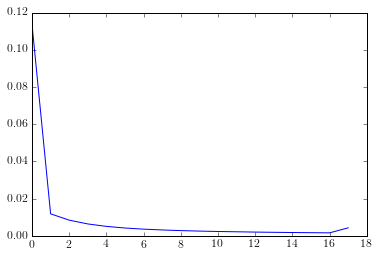

In [13]:
# How has the mean of all the paramters has changed over iterations
plt.plot(params_diff[1:])

In [15]:
# load the dataset
datasets = load_data(DATA_PREFIX+'/mnist/mnist.pkl.gz')
train_set_x, train_set_y = datasets[0]
test_set_x, test_set_y = datasets[1]

... loading data


In [16]:
dataX = test_set_x.eval()
dataY = test_set_y.eval()
predY = numpy.zeros(dataY.shape)
dataEmbedded = numpy.zeros((dataY.shape[0], 500))

In [17]:
for i in range(0,dataX.shape[0],param['batch_size']):
    predY[i:i+param['batch_size']]=pred(dataX[i:i+param['batch_size'],:])
    dataEmbedded[i:i+param['batch_size'],:]=representation(dataX[i:i+param['batch_size'],:])

## Do some visualization of the data. Feature representation using deep learning should be better than using raw features.
Here we use t-distributed stochastic neighbor embedding (t-SNE), which is a machine learning algorithm for dimensionality reduction. It allows visualization of high-dimensional data on the screen. It projects data in such a way, that points close in high dimensional space are also close in low dimensional space.

In [18]:
X_train_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(dataEmbedded)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.684203
[t-SNE] Iteration 10: error = 26.9728045, gradient norm = 0.0029743
[t-SNE] Iteration 20: error = 27.1297524, gradient norm = 0.0269100
[t-SNE] Iteration 30: error = 26.0029021, gradient norm = 0.0399844
[t-SNE] Iteration 40: error = 23.5808707, gradient norm 

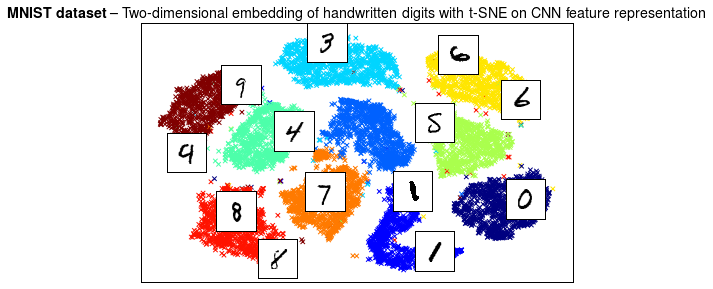

In [19]:
plot_mnist(dataX, predY, X_train_embedded,
           "t-SNE on CNN feature representation", min_dist=20.0)


In [20]:
X_tse = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(dataX)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.988302
[t-SNE] Iteration 10: error = 26.9200645, gradient norm = 0.0044221
[t-SNE] Iteration 20: error = 27.1437642, gradient norm = 0.0319798
[t-SNE] Iteration 30: error = 26.0388611, gradient norm = 0.0456271
[t-SNE] Iteration 40: error = 23.8414262, gradient norm 

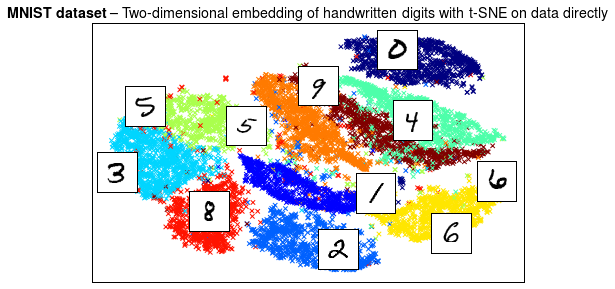

In [21]:
plot_mnist(dataX, predY, X_tse[:,:2],
           "t-SNE on data directly", min_dist=20.0)


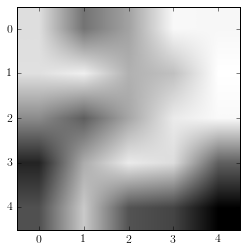

In [23]:
# Draw a single filter
plt.imshow(params_ij[4,0,:,:],cmap = cm.Greys_r)

In [27]:
def display_filter(arr):
    width = arr.shape[1]
    height = arr.shape[2]
    elements = arr.shape[0]
    cols = int(numpy.ceil(0.2* elements))
    rows =  int(numpy.ceil(elements/float(cols)))
    new_im = numpy.zeros((rows*height,cols*width))
    count =0
    
    for y in range(0,rows*height,height):
        for x in range(0,cols*width,width):
            count = count+1
            #I change brightness of the images, just to emphasise they are unique copies.
            #paste the image at location i,j:
            if ( count < elements ):
                new_im[y:y+height, x:x+width] = arr[count,:,:]
    return new_im

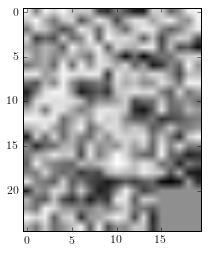

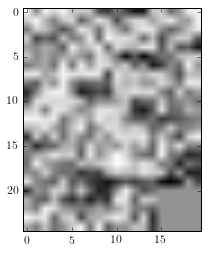

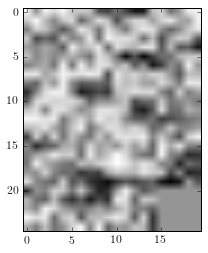

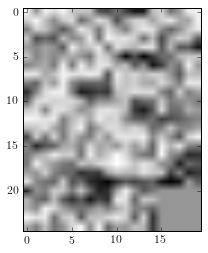

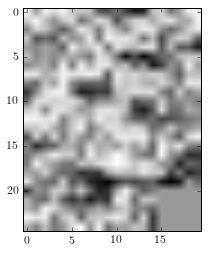

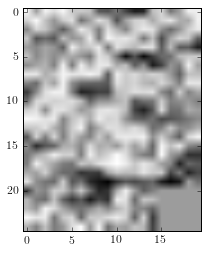

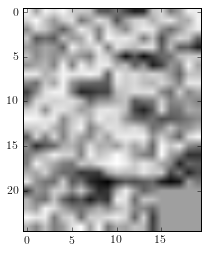

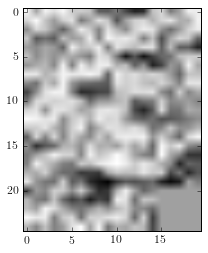

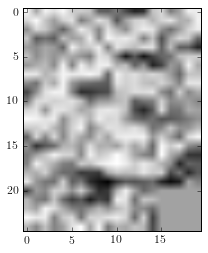

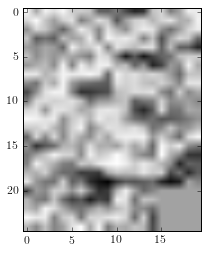

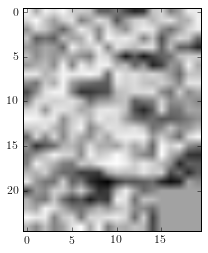

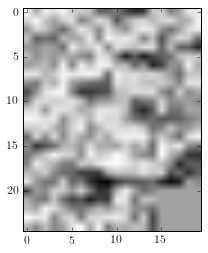

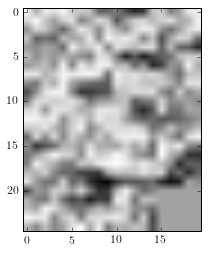

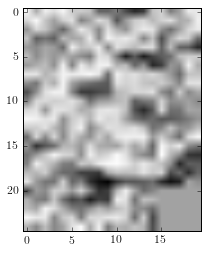

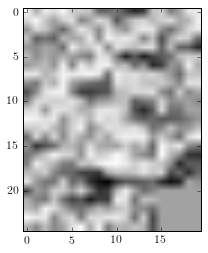

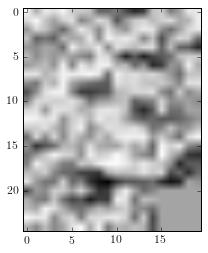

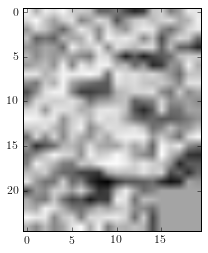

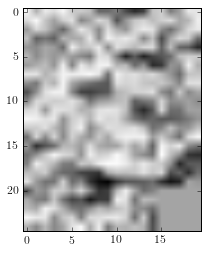

IndexError: list index out of range

In [33]:
# Draw all the filters of the first layer
for i in range(1,20):
    plt.imshow(display_filter(best_params[i][:,0,:,:]),cmap = cm.Greys_r)
    plt.show()